Continuous waveform mode
=======================

In this tutorial we will demonstrate continuous waveform mode (see [Continuous waveform mode](https://qblox-qblox-instruments.readthedocs-hosted.com/en/cluster/q1_sequence_processor.html#continuous-waveform-mode)).
In addition, we will observe the output on an oscilloscope to demonstrate the results.

In addition, we will observe the output on an oscilloscope to demonstrate the results.

This tutorial is meant for a Cluster QCM, but can be applied also to a QRM module with the opportune modifications.

To run this tutorial please make sure you have installed and enabled ipywidgets: 
```
pip install ipywidgets
jupyter nbextension enable --py widgetsnbextension
```

Setup
-----

First, we are going to import the required packages.

In [1]:
# Import ipython widgets
import json
import math
import os

import ipywidgets as widgets
import matplotlib.pyplot
import numpy

# Set up the environment.
import scipy.signal
from IPython.display import display
from ipywidgets import fixed, interact, interact_manual, interactive
from qcodes import Instrument
from qblox_instruments import Cluster, PlugAndPlay, Pulsar

### Scan For Clusters

We scan for the available clusters on our network using the Plug & Play functionality of the Qblox Instruments package (see [Plug & Play](https://qblox-qblox-instruments.readthedocs-hosted.com/en/master/api_reference/pnp.html) for more info).

In [2]:
# Scan for available devices and display
with PlugAndPlay() as p:
    # get info of all devices
    device_list = p.list_devices()

names = {
    dev_id: dev_info["description"]["name"] for dev_id, dev_info in device_list.items()
}
ip_addresses = {
    dev_id: dev_info["identity"]["ip"] for dev_id, dev_info in device_list.items()
}

# create widget for names and ip addresses
connect = widgets.Dropdown(
    options=[(names[dev_id] + " @" + ip_addresses[dev_id], dev_id)
             for dev_id in device_list.keys()],
    description="Select Device",
)
display(connect)

Dropdown(description='Select Device', options=(('Marketing-Cluster @10.10.200.99', '00015_2247_002'),), value=…

### Connect to Cluster

We now make a connection with the Cluster selected in the dropdown widget. We also define a function to find the modules we're interested in. We select the readout and control module we want to use.

In [3]:
# Connect to device
dev_id = connect.value
# Close the chosen QCodes instrument as to prevent name clash.
try:
    Instrument.find_instrument(names[dev_id]).close()
except KeyError:
    pass

cluster = Cluster(name=names[dev_id], identifier=ip_addresses[dev_id])

print(f"{connect.label} connected")
print(cluster.get_system_state())

Marketing-Cluster @10.10.200.99 connected
Status: OKAY, Flags: NONE, Slot flags: NONE


We then find all available cluster modules to connect to them individually.

In [4]:
def select_module_widget(device, select_all=False, select_rf_type: bool = False):
    """Create a widget to select modules of a certain type

    default is to show only QRM baseband

    Args:
        devices : Cluster we are currently using
        select_all (bool): ignore filters and show all modules
        select_rf_type (bool): filter RF/baseband
    """
    options = [[None, None]]

    for module in device.modules:
        if module.present():
            if select_all or (module.is_rf_type == select_rf_type):
                options.append(
                    [
                        f"{device.name} "
                        f"{module.short_name} "
                        f"({module.module_type}{'_RF' if module.is_rf_type else ''})",
                        module,
                    ]
                )
    widget = widgets.Dropdown(options=options)
    display(widget)

    return widget

In [5]:
print("Select the control module (QCM) from the available modules:")
select_module = select_module_widget(cluster, select_rf_type=False)

Select the control module (QCM) from the available modules:


Dropdown(options=([None, None], ['Marketing-Cluster module3 (QCM)', <QcmQrm: Marketing-Cluster_module3 of Clus…

Finally, we connect to the selected Cluster module. 

In [6]:
module = select_module.value
print(f"{module} connected")

<QcmQrm: Marketing-Cluster_module3 of Cluster: Marketing-Cluster> connected


### Reset the Cluster

We reset the Cluster to enter a well-defined state. Note that resetting will clear all stored parameters, so resetting between experiments is usually not desirable.

In [ ]:
cluster.reset()
print(cluster.get_system_state())

<a id='gen_wf'>Generate waveforms</a>
------------------

Next, we are going to generate a couple of waveforms that we are going to upload to the instrument in the next step.

In [7]:
# Waveform parameters
waveform_length = 120  # nanoseconds (needs to be a minimum of 4 ns)

# Waveform dictionary (data will hold the samples and index will be used to select the waveforms in the instrument).
waveforms = {
    "gaussian": {
        "data": scipy.signal.gaussian(
            waveform_length, std=0.12 * waveform_length
        ).tolist(),
        "index": 0,
    },
    "sine": {
        "data": [
            math.sin((2 * math.pi / waveform_length) * i)
            for i in range(0, waveform_length)
        ],
        "index": 1,
    },
    "sawtooth": {
        "data": [(1.0 / (waveform_length)) * i for i in range(0, waveform_length)],
        "index": 2,
    },
    "block": {"data": [1.0 for i in range(0, waveform_length)], "index": 3},
}

Let's plot the waveforms to see what we have created.

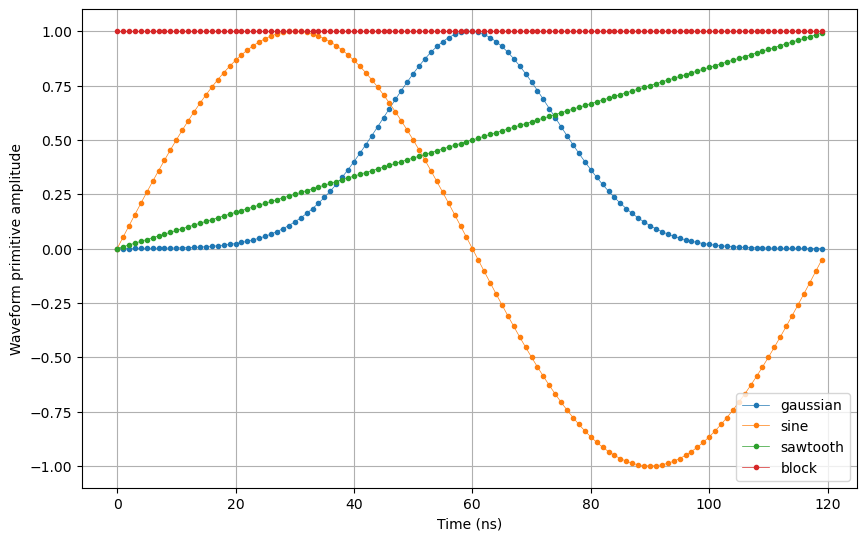

In [8]:
time = numpy.arange(
    0, max(map(lambda d: len(d["data"]), waveforms.values())), 1)
fig, ax = matplotlib.pyplot.subplots(1, 1, figsize=(10, 10 / 1.61))

for wf, d in waveforms.items():
    ax.plot(time[: len(d["data"])], d["data"], ".-", linewidth=0.5, label=wf)

ax.legend(loc=4)
ax.yaxis.grid()
ax.xaxis.grid()
ax.set_ylabel("Waveform primitive amplitude")
ax.set_xlabel("Time (ns)")

matplotlib.pyplot.draw()
matplotlib.pyplot.show()

Upload waveforms
----------------

Now that we know that the waveforms are what we expect them to be, let's upload them to the instrument.
To do this we need to store the waveforms in a JSON file together with a Q1ASM program for the sequence
processor. Since we are going to use continuous waveform mode, the sequence processor will be bypassed 
and the Q1ASM program can be trivial (i.e. `stop`).

In [9]:
# Sequence program.
seq_prog = "stop"

# Check waveform length.
for name in waveforms:
    assert (
        len(waveforms[name]["data"]) % 4
    ) == 0, (
        "In continuous waveform mode the lenght of a waveform must be a multiple of 4!"
    )

# Add sequence program and waveforms to single dictionary and write to JSON file.
sequence = {
    "waveforms": waveforms,
    "weights": {},
    "acquisitions": {},
    "program": seq_prog,
}
with open("cont_wave_mode.json", "w", encoding="utf-8") as file:
    json.dump(sequence, file, indent=4)
    file.close()

Let's write the JSON file to the instruments. We will use sequencer 0 and 1, which will drive outputs $\text{O}^{[1-2]}$ and $\text{O}^{[3-4]}$ respectively.

In [10]:
# Upload sequence.
module.sequencer0.sequence("cont_wave_mode.json")
module.sequencer1.sequence("cont_wave_mode.json")

Play waveforms
--------------

The waveforms have been uploaded to the instrument. Now we need to configure the instrument to run in continuous waveform mode. We
do this by setting the following parameters of the sequencers.

In [11]:
# Configure the sequencers to run in continuous waveform mode.
for sequencer in [module.sequencer0, module.sequencer1]:
    sequencer.cont_mode_en_awg_path0(True)
    sequencer.cont_mode_en_awg_path1(True)

# Map sequencers to specific outputs (but first disable all sequencer connections).
for sequencer in module.sequencers:
    for out in range(0, 4):
        if hasattr(sequencer, "channel_map_path{}_out{}_en".format(out % 2, out)):
            sequencer.set("channel_map_path{}_out{}_en".format(
                out % 2, out), False)

# If it is a QRM, we only map sequencer 0 to the outputs.
module.sequencer0.channel_map_path0_out0_en(True)
module.sequencer0.channel_map_path1_out1_en(True)
if module.is_qcm_type:
    module.sequencer1.channel_map_path0_out2_en(True)
    module.sequencer1.channel_map_path1_out3_en(True)

# Set specific waveform to specific output.
module.sequencer0.cont_mode_waveform_idx_awg_path0(0)  # Gaussian on O1
module.sequencer0.cont_mode_waveform_idx_awg_path1(1)  # Sine on O2
module.sequencer1.cont_mode_waveform_idx_awg_path0(2)  # Sawtooth on 03
module.sequencer1.cont_mode_waveform_idx_awg_path1(3)  # DC on O4

Now let's start playback.

In [12]:
# Arm and start both sequencers.
module.arm_sequencer(0)
module.arm_sequencer(1)
module.start_sequencer()

# Print status of both sequencers (should now say Q1 stopped, because of the stop instruction).
print(module.get_sequencer_state(0))
print(module.get_sequencer_state(1))

Status: STOPPED, Flags: NONE
Status: STOPPED, Flags: NONE


Check waveforms
---------------

The instrument is now running in continuous waveform mode. Now let's connect an oscilloscope and check the outputs.
We connect all output channels of the QXM to two/four channels of an oscilloscope.
On the scope we are able to see that all waveforms are being generated correctly:

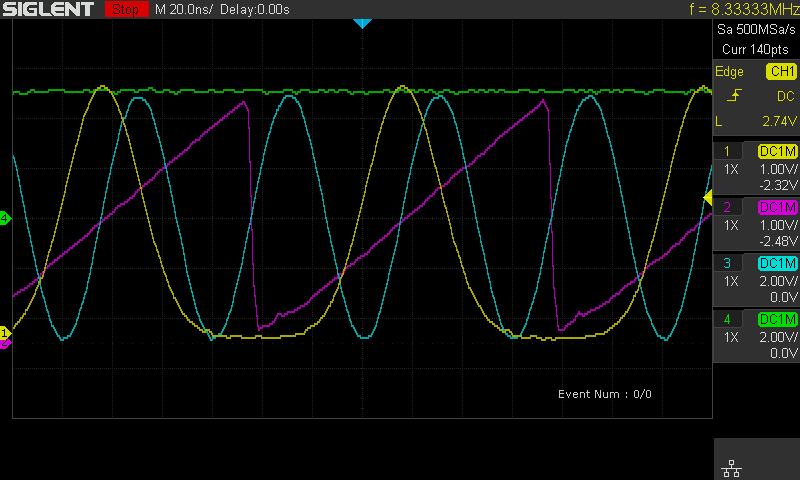

Outputs: Yellow=$\text{O}^{1}$, Blue=$\text{O}^{2}$, Purple=$\text{O}^{3}$ and Green=$\text{O}^{4}$

### Reset the Cluster

We reset the Cluster to enter a well-defined state. Note that resetting will clear all stored parameters, so resetting between experiments is usually not desirable.

In [13]:
cluster.reset()
print(cluster.get_system_state())

Status: OKAY, Flags: NONE, Slot flags: NONE
